# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Fri Jan 01 11:33:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P8    12W / 151W |    691MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019

12/26/2020  02:17 PM    <DIR>          .
12/26/2020  02:17 PM    <DIR>          ..
12/18/2019  03:27 AM            54,948 aptos_train.csv
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash - Copy.csv
12/26/2020  12:59 PM           702,068 df_train_dhash - Copy.xlsx
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
01/01/2021  11:29 AM    <DIR>          models
12/21/2020  07:33 AM    30,245,087,887 models.7z
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/17/2020  02:28 PM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/17/2020  02:28 PM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
12/19/2020  12:55 PM    <DIR>          train_images_300
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/30/2020  11:35 PM    <DIR>     

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019/'
dir_img = os.path.join(
    dir_base, 'train_images_preprocessing_v2/rescaled_300_crop_ramasubramanian')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
save_csv = 'log_training.csv'
save_EOE_train_head = 'EOE_classifier.h5'
save_best_train_head = 'best_classifier.h5'
save_EOE_train_body = 'EOE_fine_tune.h5'
save_best_train_body = 'best_fine_tune.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

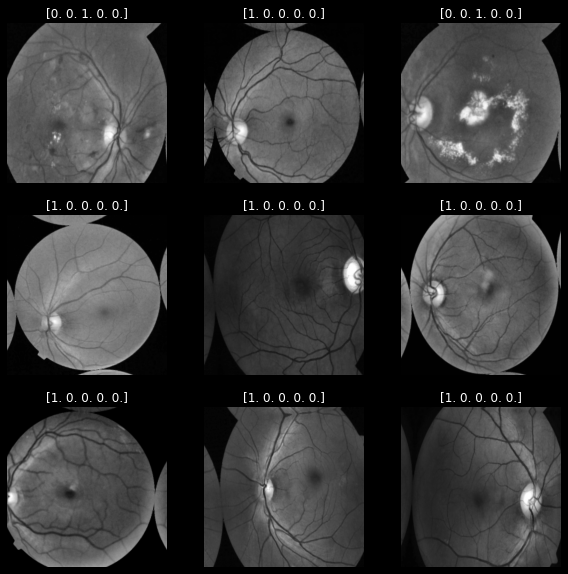

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

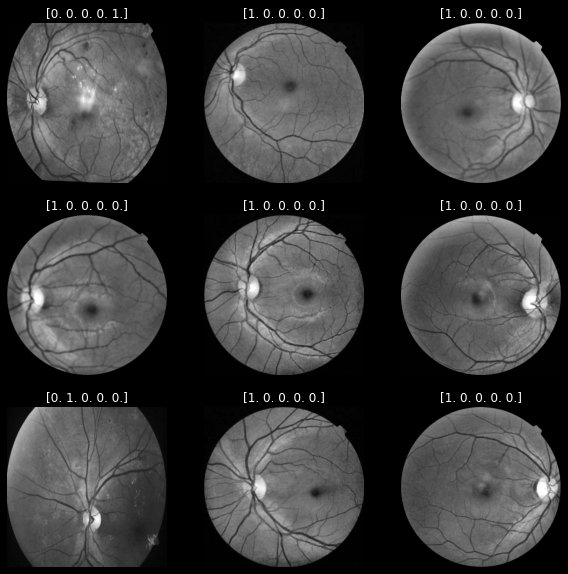

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [37]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [41]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 2s - loss: 10.7150 - categorical_accuracy: 0.4917 - precision: 0.5718 - recall: 0.4089 - auc: 0.7773
Epoch 00001: val_loss improved from inf to 9.99125, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_classifier.h5
88/88 [==============================] - 305s 3s/step - loss: 10.7046 - categorical_accuracy: 0.4939 - precision: 0.5736 - recall: 0.4110 - auc: 0.7786 - val_loss: 9.9913 - val_categorical_accuracy: 0.6171 - val_precision: 0.8576 - val_recall: 0.3786 - val_auc: 0.8812
Epoch 2/50
87/88 [============================>.] - ETA: 2s - loss: 10.1100 - categorical_accuracy: 0.5611 - precision: 0.6484 - recall: 0.4906 - auc: 0.8436
Epoch 00002: val_loss improved from 9.99125 to 9.60040, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_classifier.h5
88/88 [====

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.2278 - categorical_accuracy: 0.6880 - precision: 0.7656 - recall: 0.6128 - auc: 0.9218
Epoch 00015: val_loss improved from 6.22965 to 5.99567, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_classifier.h5
88/88 [==============================] - 141s 2s/step - loss: 6.2222 - categorical_accuracy: 0.6883 - precision: 0.7658 - recall: 0.6122 - auc: 0.9220 - val_loss: 5.9957 - val_categorical_accuracy: 0.7114 - val_precision: 0.7957 - val_recall: 0.6400 - val_auc: 0.9429
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.9748 - categorical_accuracy: 0.6963 - precision: 0.7668 - recall: 0.6265 - auc: 0.9275
Epoch 00016: val_loss improved from 5.99567 to 5.76892, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_classifier.h5
88/88 [==============================] - 140s 2s/step - loss: 5.9731 - categorical_accuracy: 0.6955 

87/88 [============================>.] - ETA: 1s - loss: 2.4759 - categorical_accuracy: 0.7603 - precision: 0.8230 - recall: 0.6808 - auc: 0.9522
Epoch 00043: val_loss improved from 2.64769 to 2.61399, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 2.4802 - categorical_accuracy: 0.7584 - precision: 0.8212 - recall: 0.6780 - auc: 0.9517 - val_loss: 2.6140 - val_categorical_accuracy: 0.7486 - val_precision: 0.8074 - val_recall: 0.6829 - val_auc: 0.9499
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.4080 - categorical_accuracy: 0.7570 - precision: 0.8119 - recall: 0.6884 - auc: 0.9508
Epoch 00044: val_loss improved from 2.61399 to 2.53781, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 2.4068 - categorical_accuracy: 0.7566 - precision:

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

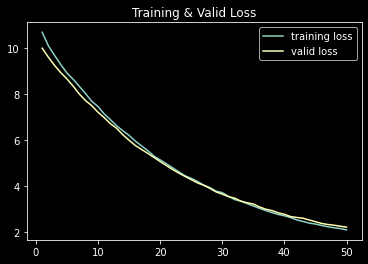

In [43]:
plot_loss(history)

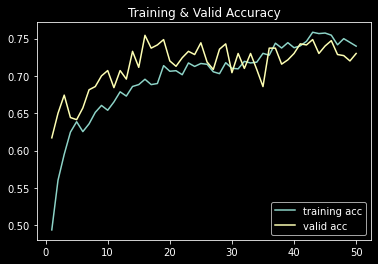

In [44]:
plot_acc(history)

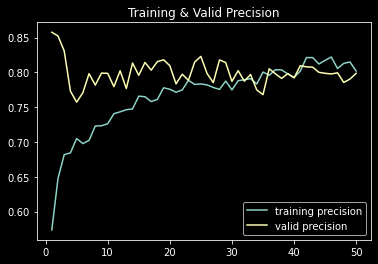

In [45]:
plot_precision(history)

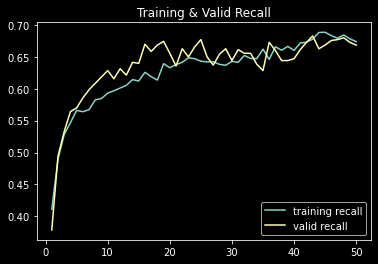

In [46]:
plot_recall(history)

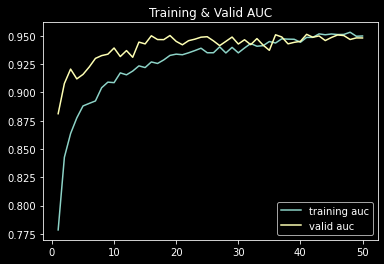

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 631ms/step - loss: 1.9575 - categorical_accuracy: 0.7300 - precision: 0.7986 - recall: 0.6686 - auc: 0.9481


[1.9575116092508489, 0.73, 0.7986348, 0.6685714, 0.9481064]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 574ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.97      0.97       359
         mild       0.49      0.49      0.49        67
     moderate       0.75      0.41      0.53       185
       severe       0.28      0.71      0.40        35
proliferative       0.35      0.54      0.42        54

     accuracy                           0.73       700
    macro avg       0.57      0.62      0.56       700
 weighted avg       0.78      0.73      0.74       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[349,   8,   0,   1,   1],
       [  8,  33,  11,   3,  12],
       [  3,  23,  75,  48,  36],
       [  0,   0,   5,  25,   5],
       [  0,   3,   9,  13,  29]], dtype=int64)

## Fine Tune

In [53]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [55]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [56]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0448 - categorical_accuracy: 0.7614 - precision: 0.8181 - recall: 0.6960 - auc: 0.9562
Epoch 00001: val_loss improved from inf to 2.22119, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_fine_tune.h5
88/88 [==============================] - 153s 2s/step - loss: 2.0422 - categorical_accuracy: 0.7623 - precision: 0.8180 - recall: 0.6955 - auc: 0.9563 - val_loss: 2.2212 - val_categorical_accuracy: 0.7386 - val_precision: 0.7997 - val_recall: 0.6729 - val_auc: 0.9500
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0643 - categorical_accuracy: 0.7711 - precision: 0.8260 - recall: 0.6967 - auc: 0.9563
Epoch 00002: val_loss improved from 2.22119 to 2.20896, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold1\best_fine_tune.h5
88/88 [=========

Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.8869 - categorical_accuracy: 0.8004 - precision: 0.8486 - recall: 0.7458 - auc: 0.9673
Epoch 00032: val_loss did not improve from 2.16936
88/88 [==============================] - 136s 2s/step - loss: 1.8859 - categorical_accuracy: 0.7995 - precision: 0.8480 - recall: 0.7455 - auc: 0.9673 - val_loss: 2.1709 - val_categorical_accuracy: 0.7571 - val_precision: 0.8058 - val_recall: 0.7114 - val_auc: 0.9556
Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.8519 - categorical_accuracy: 0.8091 - precision: 0.8594 - recall: 0.7621 - auc: 0.9700
Epoch 00033: val_loss did not improve from 2.16936
88/88 [==============================] - 136s 2s/step - loss: 1.8605 - categorical_accuracy: 0.8070 - precision: 0.8569 - recall: 0.7595 - auc: 0.9694 - val_loss: 2.1695 - val_categorical_accuracy: 0.7514 - val_precision: 0.8029 - val_recall: 0.7100 - val_auc: 0.9556
Epoch 34/50
87/88 [===========================

In [57]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

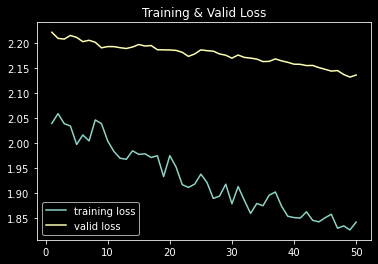

In [58]:
plot_loss(history)

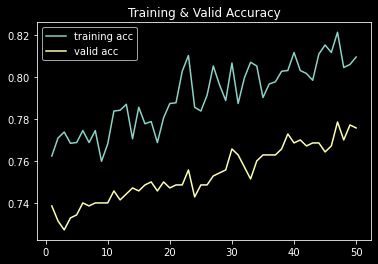

In [59]:
plot_acc(history)

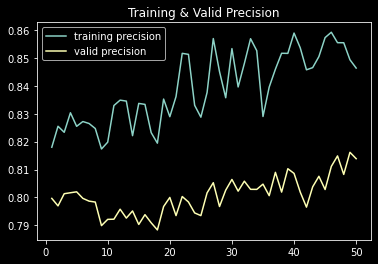

In [60]:
plot_precision(history)

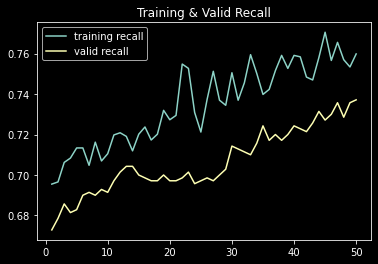

In [61]:
plot_recall(history)

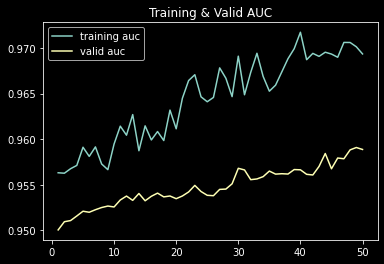

In [62]:
plot_auc(history)

### Evaluate model

In [63]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 645ms/step - loss: 1.8275 - categorical_accuracy: 0.7757 - precision: 0.8139 - recall: 0.7371 - auc: 0.9589


[1.8274621530012651, 0.7757143, 0.81388015, 0.73714286, 0.9588685]

In [64]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [65]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 632ms/step


In [66]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.98      0.98       359
         mild       0.55      0.60      0.57        67
     moderate       0.76      0.53      0.62       185
       severe       0.35      0.63      0.45        35
proliferative       0.42      0.57      0.48        54

     accuracy                           0.78       700
    macro avg       0.61      0.66      0.62       700
 weighted avg       0.80      0.78      0.78       700



In [67]:
confusion_matrix(y_true, y_pred)

array([[352,   6,   0,   0,   1],
       [  8,  40,  12,   3,   4],
       [  2,  25,  98,  28,  32],
       [  0,   0,   7,  22,   6],
       [  0,   2,  12,   9,  31]], dtype=int64)

# Fold 2

## Train classifier

In [68]:
del(model)

In [69]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [70]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [71]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))

In [72]:
conv_base, model = create_model()

In [73]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [74]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [75]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6899 - categorical_accuracy: 0.4895 - precision: 0.5622 - recall: 0.4002 - auc: 0.7759
Epoch 00001: val_loss improved from inf to 10.13264, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_classifier.h5
88/88 [==============================] - 154s 2s/step - loss: 10.6862 - categorical_accuracy: 0.4904 - precision: 0.5636 - recall: 0.4021 - auc: 0.7768 - val_loss: 10.1326 - val_categorical_accuracy: 0.5857 - val_precision: 0.8139 - val_recall: 0.3686 - val_auc: 0.8571
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0403 - categorical_accuracy: 0.5824 - precision: 0.6595 - recall: 0.5076 - auc: 0.8514
Epoch 00002: val_loss improved from 10.13264 to 9.68118, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1293 - categorical_accuracy: 0.6996 - precision: 0.7654 - recall: 0.6345 - auc: 0.9282
Epoch 00015: val_loss improved from 6.22484 to 6.03189, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_classifier.h5
88/88 [==============================] - 140s 2s/step - loss: 6.1332 - categorical_accuracy: 0.6980 - precision: 0.7635 - recall: 0.6333 - auc: 0.9278 - val_loss: 6.0319 - val_categorical_accuracy: 0.7171 - val_precision: 0.7947 - val_recall: 0.6471 - val_auc: 0.9447
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8987 - categorical_accuracy: 0.7010 - precision: 0.7721 - recall: 0.6356 - auc: 0.9329
Epoch 00016: val_loss improved from 6.03189 to 5.78917, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_classifier.h5
88/88 [==============================] - 140s 2s/step - loss: 5.8976 - categorical_accuracy: 0.7009 

87/88 [============================>.] - ETA: 1s - loss: 2.3870 - categorical_accuracy: 0.7542 - precision: 0.8047 - recall: 0.6884 - auc: 0.9529
Epoch 00043: val_loss improved from 2.69642 to 2.64000, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_classifier.h5
88/88 [==============================] - 140s 2s/step - loss: 2.3960 - categorical_accuracy: 0.7534 - precision: 0.8046 - recall: 0.6873 - auc: 0.9526 - val_loss: 2.6400 - val_categorical_accuracy: 0.7386 - val_precision: 0.8082 - val_recall: 0.6743 - val_auc: 0.9520
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3621 - categorical_accuracy: 0.7440 - precision: 0.8127 - recall: 0.6826 - auc: 0.9496
Epoch 00044: val_loss improved from 2.64000 to 2.61806, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_classifier.h5
88/88 [==============================] - 141s 2s/step - loss: 2.3586 - categorical_accuracy: 0.7441 - precision:

In [76]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

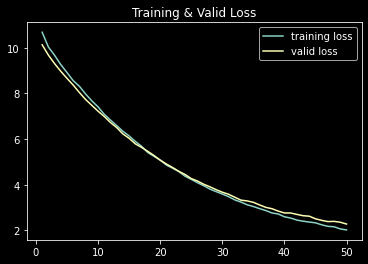

In [77]:
plot_loss(history)

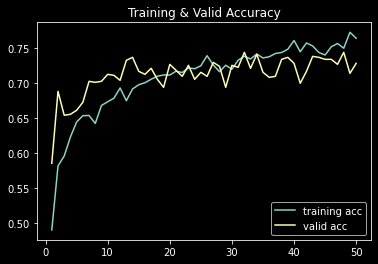

In [78]:
plot_acc(history)

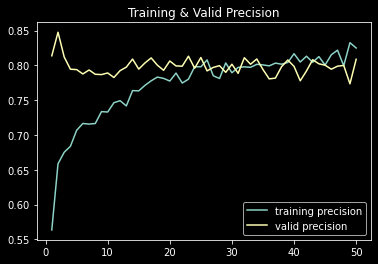

In [79]:
plot_precision(history)

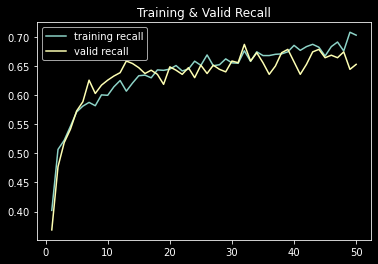

In [80]:
plot_recall(history)

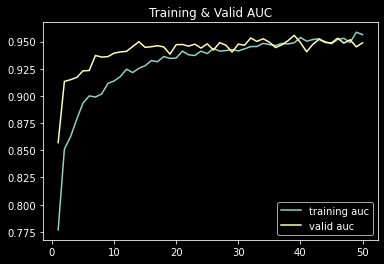

In [81]:
plot_auc(history)

### Evaluate model

In [82]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 666ms/step - loss: 1.8900 - categorical_accuracy: 0.7286 - precision: 0.8088 - recall: 0.6529 - auc: 0.9488


[1.890013732693412, 0.7285714, 0.8088496, 0.6528571, 0.94884014]

In [83]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [84]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 15s 690ms/step


In [85]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.97      0.97       359
         mild       0.53      0.47      0.50        68
     moderate       0.64      0.47      0.55       184
       severe       0.28      0.49      0.35        35
proliferative       0.30      0.48      0.37        54

     accuracy                           0.73       700
    macro avg       0.55      0.58      0.55       700
 weighted avg       0.76      0.73      0.74       700



In [86]:
confusion_matrix(y_true, y_pred)

array([[348,   5,   4,   0,   2],
       [  6,  32,  26,   0,   4],
       [  4,  20,  87,  32,  41],
       [  0,   1,   4,  17,  13],
       [  0,   2,  14,  12,  26]], dtype=int64)

## Fine Tune

In [87]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [89]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [90]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9779 - categorical_accuracy: 0.7628 - precision: 0.8179 - recall: 0.6949 - auc: 0.9553
Epoch 00001: val_loss improved from inf to 2.27706, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_fine_tune.h5
88/88 [==============================] - 157s 2s/step - loss: 1.9763 - categorical_accuracy: 0.7638 - precision: 0.8190 - recall: 0.6955 - auc: 0.9556 - val_loss: 2.2771 - val_categorical_accuracy: 0.7429 - val_precision: 0.8092 - val_recall: 0.6543 - val_auc: 0.9510
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9516 - categorical_accuracy: 0.7802 - precision: 0.8267 - recall: 0.7108 - auc: 0.9580
Epoch 00002: val_loss improved from 2.27706 to 2.27030, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_fine_tune.h5
88/88 [=========

Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.8730 - categorical_accuracy: 0.7946 - precision: 0.8393 - recall: 0.7325 - auc: 0.9662
Epoch 00016: val_loss did not improve from 2.23591
88/88 [==============================] - 141s 2s/step - loss: 1.8702 - categorical_accuracy: 0.7956 - precision: 0.8403 - recall: 0.7334 - auc: 0.9664 - val_loss: 2.2417 - val_categorical_accuracy: 0.7329 - val_precision: 0.7858 - val_recall: 0.6814 - val_auc: 0.9514
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8807 - categorical_accuracy: 0.7936 - precision: 0.8404 - recall: 0.7426 - auc: 0.9644
Epoch 00017: val_loss improved from 2.23591 to 2.23318, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold2\best_fine_tune.h5
88/88 [==============================] - 153s 2s/step - loss: 1.8808 - categorical_accuracy: 0.7931 - precision: 0.8399 - recall: 0.7423 - auc: 0.9645 - val_loss: 2.2332 - val_categorical_accuracy: 0.7357 - v

Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.8161 - categorical_accuracy: 0.8026 - precision: 0.8465 - recall: 0.7534 - auc: 0.9673
Epoch 00032: val_loss did not improve from 2.21019
88/88 [==============================] - 141s 2s/step - loss: 1.8156 - categorical_accuracy: 0.8034 - precision: 0.8467 - recall: 0.7541 - auc: 0.9675 - val_loss: 2.2131 - val_categorical_accuracy: 0.7400 - val_precision: 0.7990 - val_recall: 0.7043 - val_auc: 0.9552
Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.8167 - categorical_accuracy: 0.8008 - precision: 0.8446 - recall: 0.7523 - auc: 0.9668
Epoch 00033: val_loss did not improve from 2.21019
88/88 [==============================] - 141s 2s/step - loss: 1.8133 - categorical_accuracy: 0.8013 - precision: 0.8452 - recall: 0.7530 - auc: 0.9671 - val_loss: 2.2105 - val_categorical_accuracy: 0.7457 - val_precision: 0.7984 - val_recall: 0.7014 - val_auc: 0.9552
Epoch 34/50
87/88 [===========================

Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.7679 - categorical_accuracy: 0.8142 - precision: 0.8499 - recall: 0.7697 - auc: 0.9711
Epoch 00048: val_loss did not improve from 2.17973
88/88 [==============================] - 139s 2s/step - loss: 1.7665 - categorical_accuracy: 0.8131 - precision: 0.8486 - recall: 0.7691 - auc: 0.9709 - val_loss: 2.1906 - val_categorical_accuracy: 0.7571 - val_precision: 0.7997 - val_recall: 0.7129 - val_auc: 0.9559
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.7798 - categorical_accuracy: 0.8178 - precision: 0.8574 - recall: 0.7758 - auc: 0.9697
Epoch 00049: val_loss did not improve from 2.17973
88/88 [==============================] - 140s 2s/step - loss: 1.7822 - categorical_accuracy: 0.8167 - precision: 0.8562 - recall: 0.7748 - auc: 0.9696 - val_loss: 2.1859 - val_categorical_accuracy: 0.7557 - val_precision: 0.8032 - val_recall: 0.7171 - val_auc: 0.9563
Epoch 50/50
87/88 [===========================

In [91]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

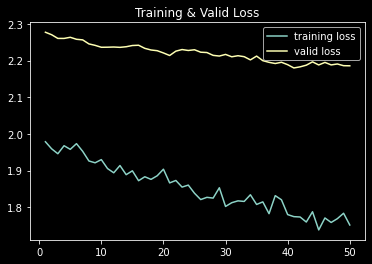

In [92]:
plot_loss(history)

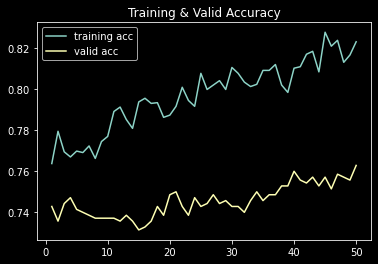

In [93]:
plot_acc(history)

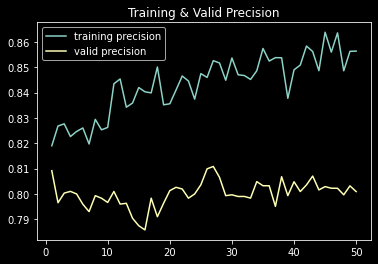

In [94]:
plot_precision(history)

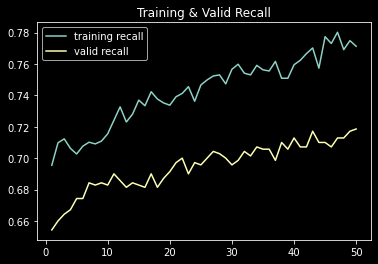

In [95]:
plot_recall(history)

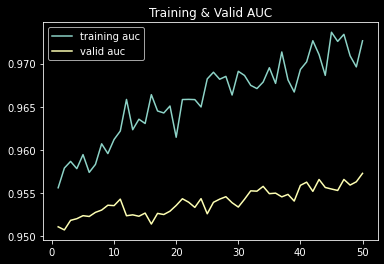

In [96]:
plot_auc(history)

### Evaluate model

In [97]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 671ms/step - loss: 1.7831 - categorical_accuracy: 0.7629 - precision: 0.8010 - recall: 0.7186 - auc: 0.9572


[1.7830767685716802, 0.76285714, 0.8009554, 0.7185714, 0.95724857]

In [98]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [99]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 608ms/step


In [100]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.98      0.98       359
         mild       0.56      0.62      0.59        68
     moderate       0.73      0.53      0.61       184
       severe       0.35      0.49      0.40        35
proliferative       0.32      0.48      0.39        54

     accuracy                           0.76       700
    macro avg       0.59      0.62      0.59       700
 weighted avg       0.79      0.76      0.77       700



In [101]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   1,   0,   1],
       [  5,  42,  15,   1,   5],
       [  4,  24,  98,  20,  38],
       [  0,   1,   6,  17,  11],
       [  0,   2,  15,  11,  26]], dtype=int64)

# Fold 3

## Train classifier

In [102]:
del(model)

In [103]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [104]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [105]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))

In [106]:
conv_base, model = create_model()

In [107]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [108]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [109]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7432 - categorical_accuracy: 0.4892 - precision: 0.5719 - recall: 0.4024 - auc: 0.7675
Epoch 00001: val_loss improved from inf to 10.16628, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_classifier.h5
88/88 [==============================] - 158s 2s/step - loss: 10.7340 - categorical_accuracy: 0.4914 - precision: 0.5740 - recall: 0.4046 - auc: 0.7687 - val_loss: 10.1663 - val_categorical_accuracy: 0.5300 - val_precision: 0.7231 - val_recall: 0.3357 - val_auc: 0.8184
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0701 - categorical_accuracy: 0.5889 - precision: 0.6609 - recall: 0.5087 - auc: 0.8515
Epoch 00002: val_loss improved from 10.16628 to 9.69068, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1462 - categorical_accuracy: 0.6855 - precision: 0.7520 - recall: 0.6095 - auc: 0.9217
Epoch 00015: val_loss improved from 6.35009 to 6.10248, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_classifier.h5
88/88 [==============================] - 143s 2s/step - loss: 6.1449 - categorical_accuracy: 0.6858 - precision: 0.7525 - recall: 0.6086 - auc: 0.9218 - val_loss: 6.1025 - val_categorical_accuracy: 0.7400 - val_precision: 0.8237 - val_recall: 0.6743 - val_auc: 0.9460
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.9400 - categorical_accuracy: 0.6985 - precision: 0.7735 - recall: 0.6247 - auc: 0.9292
Epoch 00016: val_loss improved from 6.10248 to 5.90614, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_classifier.h5
88/88 [==============================] - 143s 2s/step - loss: 5.9353 - categorical_accuracy: 0.6994 

87/88 [============================>.] - ETA: 1s - loss: 2.4301 - categorical_accuracy: 0.7502 - precision: 0.8203 - recall: 0.6782 - auc: 0.9512
Epoch 00043: val_loss improved from 2.72024 to 2.61984, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 2.4276 - categorical_accuracy: 0.7491 - precision: 0.8194 - recall: 0.6780 - auc: 0.9511 - val_loss: 2.6198 - val_categorical_accuracy: 0.7657 - val_precision: 0.8325 - val_recall: 0.7029 - val_auc: 0.9530
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3684 - categorical_accuracy: 0.7375 - precision: 0.8068 - recall: 0.6750 - auc: 0.9490
Epoch 00044: val_loss improved from 2.61984 to 2.57743, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_classifier.h5
88/88 [==============================] - 146s 2s/step - loss: 2.3718 - categorical_accuracy: 0.7373 - precision:

In [110]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

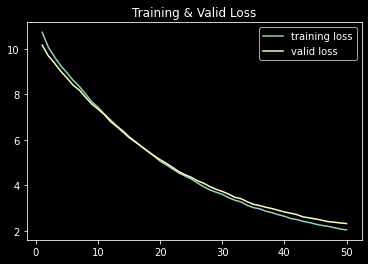

In [111]:
plot_loss(history)

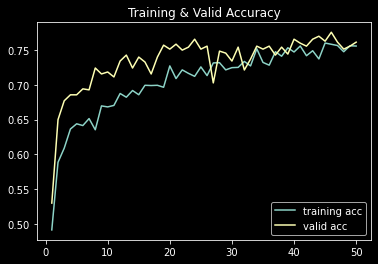

In [112]:
plot_acc(history)

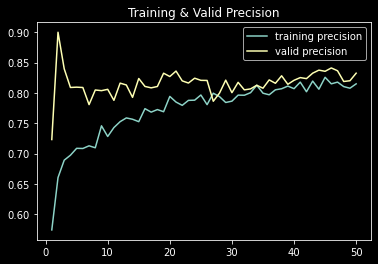

In [113]:
plot_precision(history)

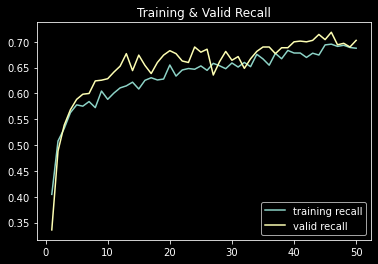

In [114]:
plot_recall(history)

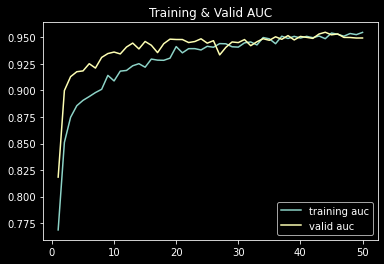

In [115]:
plot_auc(history)

### Evaluate model

In [116]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 682ms/step - loss: 1.9235 - categorical_accuracy: 0.7614 - precision: 0.8325 - recall: 0.7029 - auc: 0.9493


[1.923481746153398, 0.7614286, 0.8324873, 0.70285714, 0.94927037]

In [117]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [118]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 609ms/step


In [119]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.99      0.96       359
         mild       0.55      0.40      0.46        68
     moderate       0.75      0.54      0.63       184
       severe       0.36      0.57      0.44        35
proliferative       0.37      0.57      0.45        54

     accuracy                           0.76       700
    macro avg       0.59      0.61      0.59       700
 weighted avg       0.78      0.76      0.76       700



In [120]:
confusion_matrix(y_true, y_pred)

array([[356,   2,   1,   0,   0],
       [ 13,  27,  17,   2,   9],
       [  9,  13,  99,  27,  36],
       [  0,   3,   4,  20,   8],
       [  1,   4,  11,   7,  31]], dtype=int64)

## Fine Tune

In [121]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [122]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [123]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [124]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9587 - categorical_accuracy: 0.7827 - precision: 0.8364 - recall: 0.7169 - auc: 0.9618
Epoch 00001: val_loss improved from inf to 2.31519, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_fine_tune.h5
88/88 [==============================] - 161s 2s/step - loss: 1.9582 - categorical_accuracy: 0.7838 - precision: 0.8378 - recall: 0.7184 - auc: 0.9622 - val_loss: 2.3152 - val_categorical_accuracy: 0.7686 - val_precision: 0.8342 - val_recall: 0.7043 - val_auc: 0.9509
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9746 - categorical_accuracy: 0.7697 - precision: 0.8242 - recall: 0.7032 - auc: 0.9580
Epoch 00002: val_loss improved from 2.31519 to 2.30933, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold3\best_fine_tune.h5
88/88 [=========

Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 1.8795 - categorical_accuracy: 0.7950 - precision: 0.8412 - recall: 0.7451 - auc: 0.9658
Epoch 00030: val_loss did not improve from 2.23060
88/88 [==============================] - 140s 2s/step - loss: 1.8775 - categorical_accuracy: 0.7959 - precision: 0.8422 - recall: 0.7459 - auc: 0.9658 - val_loss: 2.2403 - val_categorical_accuracy: 0.7743 - val_precision: 0.8217 - val_recall: 0.7243 - val_auc: 0.9555
Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.8443 - categorical_accuracy: 0.8062 - precision: 0.8494 - recall: 0.7502 - auc: 0.9675
Epoch 00031: val_loss did not improve from 2.23060
88/88 [==============================] - 140s 2s/step - loss: 1.8459 - categorical_accuracy: 0.8049 - precision: 0.8483 - recall: 0.7495 - auc: 0.9674 - val_loss: 2.2359 - val_categorical_accuracy: 0.7671 - val_precision: 0.8247 - val_recall: 0.7257 - val_auc: 0.9562
Epoch 32/50
87/88 [===========================

In [125]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

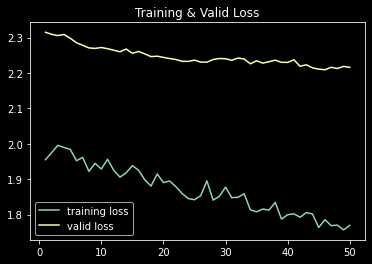

In [126]:
plot_loss(history)

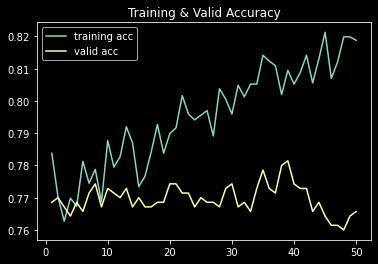

In [127]:
plot_acc(history)

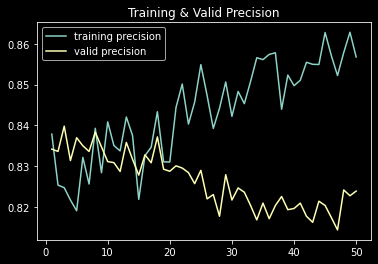

In [128]:
plot_precision(history)

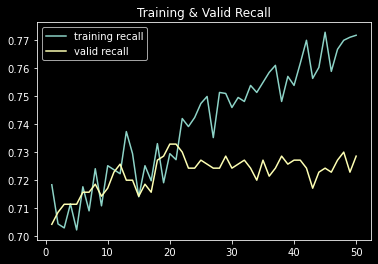

In [129]:
plot_recall(history)

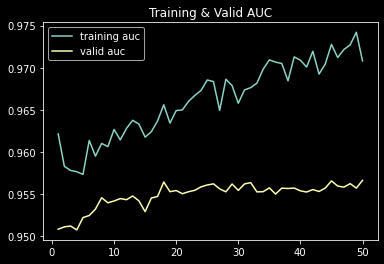

In [130]:
plot_auc(history)

### Evaluate model

In [131]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 676ms/step - loss: 1.8116 - categorical_accuracy: 0.7657 - precision: 0.8239 - recall: 0.7286 - auc: 0.9566


[1.8116227009079673, 0.7657143, 0.8239095, 0.7285714, 0.9566431]

In [132]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [133]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 615ms/step


In [134]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.97      0.97       359
         mild       0.47      0.59      0.52        68
     moderate       0.77      0.54      0.63       184
       severe       0.38      0.46      0.42        35
proliferative       0.40      0.57      0.47        54

     accuracy                           0.77       700
    macro avg       0.59      0.63      0.60       700
 weighted avg       0.79      0.77      0.77       700



In [135]:
confusion_matrix(y_true, y_pred)

array([[350,   9,   0,   0,   0],
       [  9,  40,  13,   1,   5],
       [  6,  29,  99,  20,  30],
       [  0,   2,   5,  16,  12],
       [  0,   6,  12,   5,  31]], dtype=int64)

# Fold 4

## Train classifier

In [136]:
del(model)

In [137]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [138]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [139]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))

In [140]:
conv_base, model = create_model()

In [141]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [142]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [143]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6864 - categorical_accuracy: 0.4940 - precision: 0.5741 - recall: 0.4131 - auc: 0.7810
Epoch 00001: val_loss improved from inf to 10.04229, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_classifier.h5
88/88 [==============================] - 160s 2s/step - loss: 10.6793 - categorical_accuracy: 0.4948 - precision: 0.5749 - recall: 0.4141 - auc: 0.7817 - val_loss: 10.0423 - val_categorical_accuracy: 0.5665 - val_precision: 0.8456 - val_recall: 0.3290 - val_auc: 0.8451
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0236 - categorical_accuracy: 0.5866 - precision: 0.6652 - recall: 0.5070 - auc: 0.8485
Epoch 00002: val_loss improved from 10.04229 to 9.59777, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1275 - categorical_accuracy: 0.6957 - precision: 0.7558 - recall: 0.6198 - auc: 0.9268
Epoch 00015: val_loss improved from 6.24775 to 6.01710, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 6.1216 - categorical_accuracy: 0.6967 - precision: 0.7570 - recall: 0.6199 - auc: 0.9271 - val_loss: 6.0171 - val_categorical_accuracy: 0.7225 - val_precision: 0.8177 - val_recall: 0.6609 - val_auc: 0.9498
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8676 - categorical_accuracy: 0.6979 - precision: 0.7684 - recall: 0.6343 - auc: 0.9279
Epoch 00016: val_loss improved from 6.01710 to 5.80810, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 5.8684 - categorical_accuracy: 0.6985 

87/88 [============================>.] - ETA: 1s - loss: 2.3945 - categorical_accuracy: 0.7477 - precision: 0.8133 - recall: 0.6784 - auc: 0.9522
Epoch 00043: val_loss improved from 2.64449 to 2.59881, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 2.3914 - categorical_accuracy: 0.7467 - precision: 0.8131 - recall: 0.6777 - auc: 0.9523 - val_loss: 2.5988 - val_categorical_accuracy: 0.7454 - val_precision: 0.8020 - val_recall: 0.6838 - val_auc: 0.9547
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3484 - categorical_accuracy: 0.7539 - precision: 0.8119 - recall: 0.6943 - auc: 0.9523
Epoch 00044: val_loss improved from 2.59881 to 2.54513, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 2.3461 - categorical_accuracy: 0.7538 - precision:

In [144]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

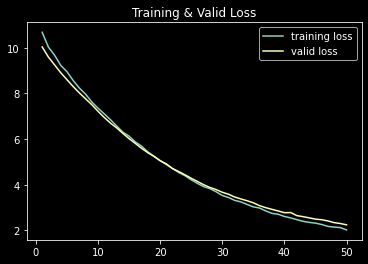

In [145]:
plot_loss(history)

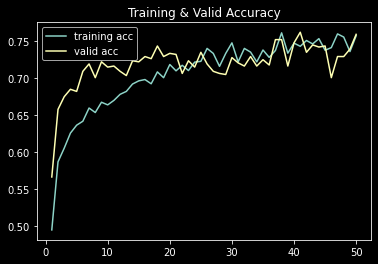

In [146]:
plot_acc(history)

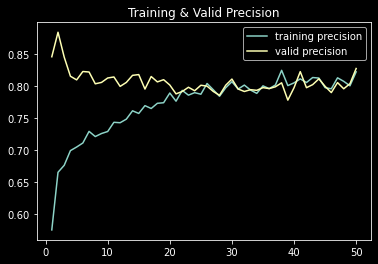

In [147]:
plot_precision(history)

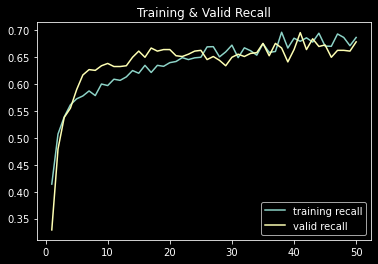

In [148]:
plot_recall(history)

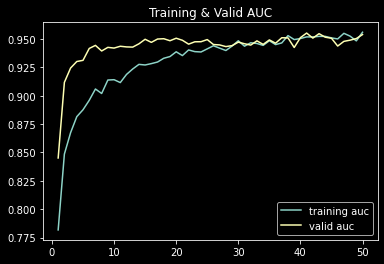

In [149]:
plot_auc(history)

### Evaluate model

In [150]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 665ms/step - loss: 1.8641 - categorical_accuracy: 0.7597 - precision: 0.8272 - recall: 0.6781 - auc: 0.9539


[1.8641363219781355, 0.75965667, 0.82722515, 0.6781116, 0.95393544]

In [151]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [152]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 612ms/step


In [153]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       359
         mild       0.53      0.54      0.54        68
     moderate       0.72      0.55      0.63       184
       severe       0.31      0.62      0.42        34
proliferative       0.36      0.37      0.36        54

     accuracy                           0.76       699
    macro avg       0.58      0.61      0.58       699
 weighted avg       0.78      0.76      0.76       699



In [154]:
confusion_matrix(y_true, y_pred)

array([[351,   7,   1,   0,   0],
       [  9,  37,  20,   0,   2],
       [  4,  23, 102,  27,  28],
       [  0,   1,   6,  21,   6],
       [  0,   2,  13,  19,  20]], dtype=int64)

## Fine Tune

In [155]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [156]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [157]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [158]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9798 - categorical_accuracy: 0.7788 - precision: 0.8290 - recall: 0.7185 - auc: 0.9604
Epoch 00001: val_loss improved from inf to 2.24482, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_fine_tune.h5
88/88 [==============================] - 160s 2s/step - loss: 1.9829 - categorical_accuracy: 0.7767 - precision: 0.8269 - recall: 0.7167 - auc: 0.9597 - val_loss: 2.2448 - val_categorical_accuracy: 0.7568 - val_precision: 0.8198 - val_recall: 0.6767 - val_auc: 0.9546
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0206 - categorical_accuracy: 0.7669 - precision: 0.8242 - recall: 0.6982 - auc: 0.9563
Epoch 00002: val_loss did not improve from 2.24482
88/88 [==============================] - 140s 2s/step - loss: 2.0264 - categorical_accuracy: 0.7674 - precision: 0.8249 - 

Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8849 - categorical_accuracy: 0.7810 - precision: 0.8337 - recall: 0.7318 - auc: 0.9645
Epoch 00017: val_loss did not improve from 2.23108
88/88 [==============================] - 142s 2s/step - loss: 1.8844 - categorical_accuracy: 0.7810 - precision: 0.8335 - recall: 0.7317 - auc: 0.9647 - val_loss: 2.2316 - val_categorical_accuracy: 0.7554 - val_precision: 0.8066 - val_recall: 0.6981 - val_auc: 0.9543
Epoch 18/50
87/88 [============================>.] - ETA: 1s - loss: 1.8907 - categorical_accuracy: 0.7929 - precision: 0.8378 - recall: 0.7355 - auc: 0.9652
Epoch 00018: val_loss improved from 2.23108 to 2.22348, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold4\best_fine_tune.h5
88/88 [==============================] - 145s 2s/step - loss: 1.8885 - categorical_accuracy: 0.7921 - precision: 0.8362 - recall: 0.7349 - auc: 0.9651 - val_loss: 2.2235 - val_categorical_accuracy: 0.7625 - v

Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.8353 - categorical_accuracy: 0.8012 - precision: 0.8427 - recall: 0.7492 - auc: 0.9671
Epoch 00033: val_loss did not improve from 2.19950
88/88 [==============================] - 141s 2s/step - loss: 1.8408 - categorical_accuracy: 0.8006 - precision: 0.8424 - recall: 0.7485 - auc: 0.9670 - val_loss: 2.1998 - val_categorical_accuracy: 0.7611 - val_precision: 0.8013 - val_recall: 0.7096 - val_auc: 0.9545
Epoch 34/50
87/88 [============================>.] - ETA: 1s - loss: 1.8291 - categorical_accuracy: 0.8088 - precision: 0.8475 - recall: 0.7514 - auc: 0.9696
Epoch 00034: val_loss did not improve from 2.19950
88/88 [==============================] - 141s 2s/step - loss: 1.8289 - categorical_accuracy: 0.8081 - precision: 0.8472 - recall: 0.7510 - auc: 0.9695 - val_loss: 2.2075 - val_categorical_accuracy: 0.7625 - val_precision: 0.8016 - val_recall: 0.7110 - val_auc: 0.9547
Epoch 35/50
87/88 [===========================

Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.7749 - categorical_accuracy: 0.8135 - precision: 0.8571 - recall: 0.7633 - auc: 0.9718
Epoch 00050: val_loss did not improve from 2.18225
88/88 [==============================] - 141s 2s/step - loss: 1.7734 - categorical_accuracy: 0.8139 - precision: 0.8577 - recall: 0.7642 - auc: 0.9719 - val_loss: 2.1861 - val_categorical_accuracy: 0.7625 - val_precision: 0.8032 - val_recall: 0.7182 - val_auc: 0.9549


In [159]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

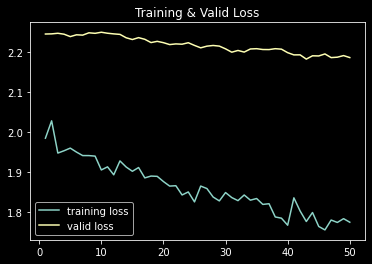

In [160]:
plot_loss(history)

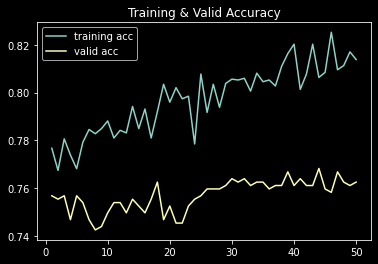

In [161]:
plot_acc(history)

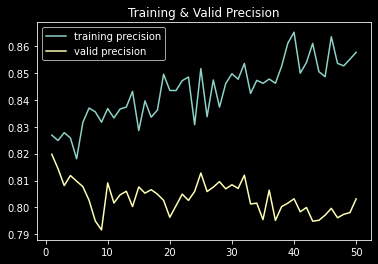

In [162]:
plot_precision(history)

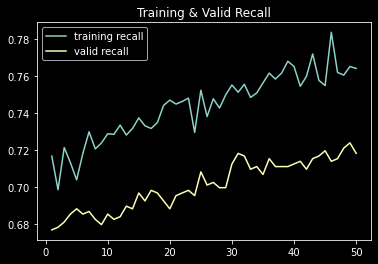

In [163]:
plot_recall(history)

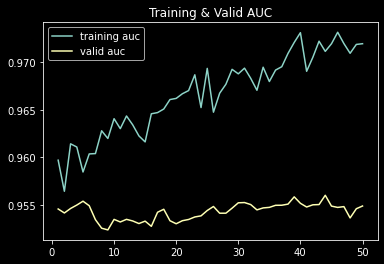

In [164]:
plot_auc(history)

### Evaluate model

In [165]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 680ms/step - loss: 1.8090 - categorical_accuracy: 0.7625 - precision: 0.8032 - recall: 0.7182 - auc: 0.9549


[1.808951117775657, 0.76251787, 0.8032, 0.7181688, 0.95490795]

In [166]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [167]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 614ms/step


In [168]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.97      0.97       359
         mild       0.49      0.60      0.54        68
     moderate       0.73      0.52      0.61       184
       severe       0.38      0.62      0.47        34
proliferative       0.39      0.48      0.43        54

     accuracy                           0.76       699
    macro avg       0.59      0.64      0.60       699
 weighted avg       0.78      0.76      0.77       699



In [169]:
confusion_matrix(y_true, y_pred)

array([[350,   7,   2,   0,   0],
       [  8,  41,  15,   0,   4],
       [  6,  33,  95,  20,  30],
       [  0,   1,   6,  21,   6],
       [  0,   2,  12,  14,  26]], dtype=int64)

# Fold 5

## Train classifier

In [170]:
del(model)

In [171]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [172]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [173]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_ramasubramanian/fold'+str(fold))

In [174]:
conv_base, model = create_model()

In [175]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [176]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [177]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7669 - categorical_accuracy: 0.4897 - precision: 0.5778 - recall: 0.4091 - auc: 0.7722
Epoch 00001: val_loss improved from inf to 10.05406, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_classifier.h5
88/88 [==============================] - 157s 2s/step - loss: 10.7610 - categorical_accuracy: 0.4927 - precision: 0.5804 - recall: 0.4116 - auc: 0.7737 - val_loss: 10.0541 - val_categorical_accuracy: 0.6037 - val_precision: 0.8068 - val_recall: 0.3405 - val_auc: 0.8530
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1008 - categorical_accuracy: 0.5757 - precision: 0.6594 - recall: 0.5052 - auc: 0.8465
Epoch 00002: val_loss improved from 10.05406 to 9.59729, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_classifier.h5
88/88 [=

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.0555 - categorical_accuracy: 0.6928 - precision: 0.7644 - recall: 0.6216 - auc: 0.9286
Epoch 00015: val_loss improved from 6.35937 to 6.07485, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 6.0564 - categorical_accuracy: 0.6935 - precision: 0.7647 - recall: 0.6224 - auc: 0.9289 - val_loss: 6.0748 - val_categorical_accuracy: 0.7182 - val_precision: 0.7907 - val_recall: 0.6538 - val_auc: 0.9370
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8542 - categorical_accuracy: 0.6986 - precision: 0.7678 - recall: 0.6274 - auc: 0.9308
Epoch 00016: val_loss improved from 6.07485 to 5.88556, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_classifier.h5
88/88 [==============================] - 146s 2s/step - loss: 5.8549 - categorical_accuracy: 0.6981 

87/88 [============================>.] - ETA: 1s - loss: 2.3578 - categorical_accuracy: 0.7557 - precision: 0.8095 - recall: 0.6881 - auc: 0.9543
Epoch 00043: val_loss improved from 2.68532 to 2.68438, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 2.3548 - categorical_accuracy: 0.7553 - precision: 0.8092 - recall: 0.6877 - auc: 0.9542 - val_loss: 2.6844 - val_categorical_accuracy: 0.7225 - val_precision: 0.7917 - val_recall: 0.6581 - val_auc: 0.9443
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.2957 - categorical_accuracy: 0.7550 - precision: 0.8087 - recall: 0.6983 - auc: 0.9563
Epoch 00044: val_loss improved from 2.68438 to 2.63715, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_classifier.h5
88/88 [==============================] - 144s 2s/step - loss: 2.2897 - categorical_accuracy: 0.7560 - precision:

In [178]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

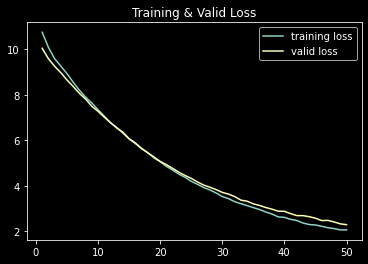

In [179]:
plot_loss(history)

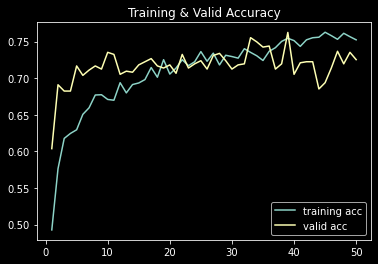

In [180]:
plot_acc(history)

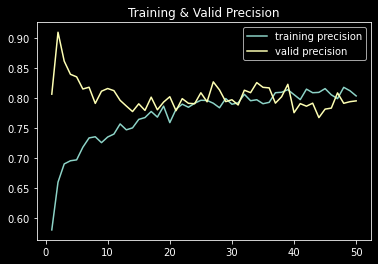

In [181]:
plot_precision(history)

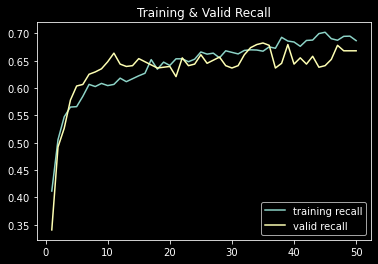

In [182]:
plot_recall(history)

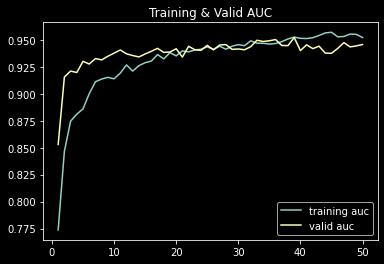

In [183]:
plot_auc(history)

### Evaluate model

In [184]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 677ms/step - loss: 1.9242 - categorical_accuracy: 0.7253 - precision: 0.7956 - recall: 0.6681 - auc: 0.9458


[1.9242076548663052, 0.7253219, 0.7955707, 0.66809726, 0.9458063]

In [185]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [186]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 618ms/step


In [187]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.92      0.97      0.95       360
         mild       0.49      0.49      0.49        67
     moderate       0.78      0.42      0.54       184
       severe       0.21      0.41      0.27        34
proliferative       0.39      0.59      0.47        54

     accuracy                           0.73       699
    macro avg       0.56      0.58      0.54       699
 weighted avg       0.76      0.73      0.73       699



In [188]:
confusion_matrix(y_true, y_pred)

array([[351,   5,   1,   0,   3],
       [ 14,  33,  11,   2,   7],
       [ 14,  23,  77,  40,  30],
       [  2,   0,   7,  14,  11],
       [  1,   6,   3,  12,  32]], dtype=int64)

## Fine Tune

In [189]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [190]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [191]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [192]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9696 - categorical_accuracy: 0.7673 - precision: 0.8266 - recall: 0.6993 - auc: 0.9575
Epoch 00001: val_loss improved from inf to 2.27975, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_fine_tune.h5
88/88 [==============================] - 162s 2s/step - loss: 1.9696 - categorical_accuracy: 0.7674 - precision: 0.8264 - recall: 0.6988 - auc: 0.9574 - val_loss: 2.2798 - val_categorical_accuracy: 0.7268 - val_precision: 0.7966 - val_recall: 0.6724 - val_auc: 0.9466
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9864 - categorical_accuracy: 0.7611 - precision: 0.8119 - recall: 0.7004 - auc: 0.9561
Epoch 00002: val_loss improved from 2.27975 to 2.26499, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_ramasubramanian/fold5\best_fine_tune.h5
88/88 [=========

88/88 [==============================] - 144s 2s/step - loss: 1.8782 - categorical_accuracy: 0.7849 - precision: 0.8319 - recall: 0.7356 - auc: 0.9643 - val_loss: 2.2430 - val_categorical_accuracy: 0.7454 - val_precision: 0.8103 - val_recall: 0.6967 - val_auc: 0.9510
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.9023 - categorical_accuracy: 0.7864 - precision: 0.8278 - recall: 0.7279 - auc: 0.9639
Epoch 00017: val_loss did not improve from 2.24305
88/88 [==============================] - 141s 2s/step - loss: 1.9017 - categorical_accuracy: 0.7878 - precision: 0.8292 - recall: 0.7285 - auc: 0.9642 - val_loss: 2.2440 - val_categorical_accuracy: 0.7439 - val_precision: 0.8073 - val_recall: 0.6953 - val_auc: 0.9508
Epoch 18/50
87/88 [============================>.] - ETA: 1s - loss: 1.8492 - categorical_accuracy: 0.7976 - precision: 0.8421 - recall: 0.7441 - auc: 0.9667
Epoch 00018: val_loss did not improve from 2.24305
88/88 [==============================] - 141s 

Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.7412 - categorical_accuracy: 0.8236 - precision: 0.8588 - recall: 0.7781 - auc: 0.9721
Epoch 00048: val_loss did not improve from 2.20322
88/88 [==============================] - 141s 2s/step - loss: 1.7396 - categorical_accuracy: 0.8242 - precision: 0.8593 - recall: 0.7792 - auc: 0.9724 - val_loss: 2.2197 - val_categorical_accuracy: 0.7654 - val_precision: 0.8163 - val_recall: 0.7182 - val_auc: 0.9548
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.7599 - categorical_accuracy: 0.8128 - precision: 0.8474 - recall: 0.7709 - auc: 0.9722
Epoch 00049: val_loss did not improve from 2.20322
88/88 [==============================] - 141s 2s/step - loss: 1.7617 - categorical_accuracy: 0.8124 - precision: 0.8475 - recall: 0.7706 - auc: 0.9721 - val_loss: 2.2168 - val_categorical_accuracy: 0.7654 - val_precision: 0.8160 - val_recall: 0.7167 - val_auc: 0.9545
Epoch 50/50
87/88 [===========================

In [193]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

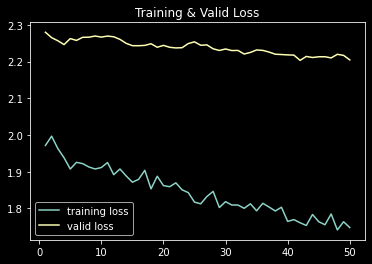

In [194]:
plot_loss(history)

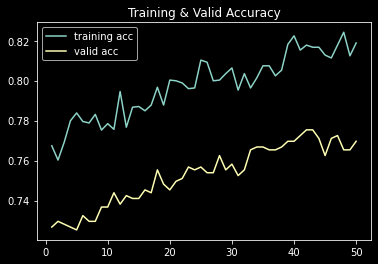

In [195]:
plot_acc(history)

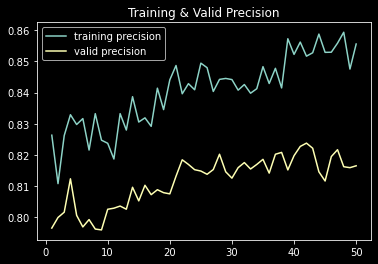

In [196]:
plot_precision(history)

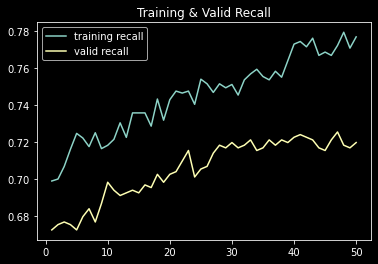

In [197]:
plot_recall(history)

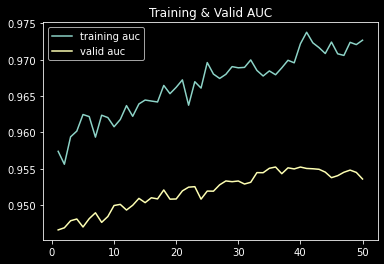

In [198]:
plot_auc(history)

### Evaluate model

In [199]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 671ms/step - loss: 1.8067 - categorical_accuracy: 0.7697 - precision: 0.8166 - recall: 0.7196 - auc: 0.9536


[1.8067214488983154, 0.76967096, 0.8165584, 0.7195994, 0.9535764]

In [200]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [201]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 643ms/step


In [202]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.97      0.97       360
         mild       0.54      0.57      0.55        67
     moderate       0.78      0.55      0.65       184
       severe       0.32      0.41      0.36        34
proliferative       0.37      0.63      0.47        54

     accuracy                           0.77       699
    macro avg       0.60      0.63      0.60       699
 weighted avg       0.80      0.77      0.78       699



In [203]:
confusion_matrix(y_true, y_pred)

array([[350,   6,   1,   0,   3],
       [ 10,  38,  11,   2,   6],
       [  3,  20, 102,  21,  38],
       [  0,   0,  10,  14,  10],
       [  0,   7,   6,   7,  34]], dtype=int64)